In [1]:
import math
import random
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pykalman import KalmanFilter
from pykalman.utils import array1d, array2d, check_random_state, get_params, log_multivariate_normal_density, preprocess_arguments
from pykalman.standard import _filter, _smooth, _smooth_pair, _em

DIM = {
    'transition_matrices': 2,
    'transition_offsets': 1,
    'observation_matrices': 2,
    'observation_offsets': 1,
    'transition_covariance': 2,
    'observation_covariance': 2,
    'initial_state_mean': 1,
    'initial_state_covariance': 2,
}

In [2]:
def sin_wave(A, omega, fai, length):
	# A*sin(ωt - φ)
	x = np.linspace(0, 2*np.pi*(length/omega), length)
	return A*np.sin(x - fai)
def cos_wave(A, omega, fai, length):
	# A*cos(ωt - φ)
	x = np.linspace(0, 2*np.pi*(length/omega), length)
	return A*np.cos(x - fai)

# 使用するデータ

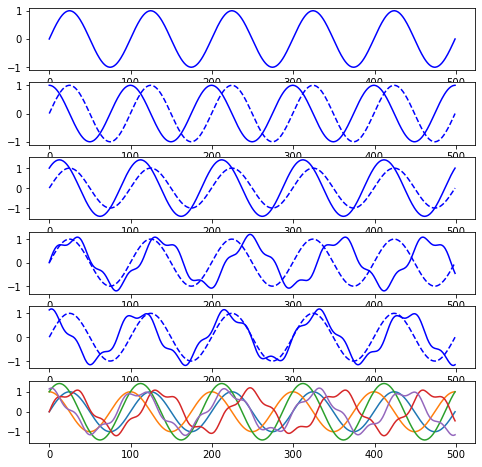

In [3]:
x1 = sin_wave(1, 100, 0, 500)
x2 = cos_wave(1, 100, 0, 500)
x3 = sin_wave(1, 100, 0, 500) + cos_wave(1, 100, 0, 500)
x4 = sin_wave(1, 110, 0, 500) + sin_wave(0.2, 30, 0, 500)
x5 = cos_wave(1, 110, 0, 500) + sin_wave(0.2, 30, -np.pi/4, 500)
X = np.array([x1,x2,x3,x4,x5]).T

plt.figure(figsize=(8,8))
plt.subplot(611)
plt.plot(x1,color='b')
plt.subplot(612)
plt.plot(x2,color='b')
plt.plot(x1,color='b',linestyle='dashed')
plt.subplot(613)
plt.plot(x3,color='b')
plt.plot(x1,color='b',linestyle='dashed')
plt.subplot(614)
plt.plot(x4,color='b')
plt.plot(x1,color='b',linestyle='dashed')
plt.subplot(615)
plt.plot(x5,color='b')
plt.plot(x1,color='b',linestyle='dashed')
plt.subplot(616)
plt.plot(X)

In [4]:
def missing_matrix(X, missing_len=0.05, missing_num=10):
	#連続した欠損値を生成する
	#X = (Time, dim)
	#missing_len 全体の長さ(Time)のうちどれだけの割合を欠損値にするか
	#missing_num 欠損値の数
	#W: if X[i,j] == nan then W[i,j] == 0 else W[i,j] == 1

	W = np.ones(X.shape)
	(r, l) = X.shape
	#missing_point[[row, startpoint, length],[],...]
	missing_points = [[random.randint(0,l-1), random.randint(0,r-1), random.randint(0,int(r*missing_len))] for i in range(missing_num)]

	for point in missing_points:
		if point[1]+point[2]>=r:
			end=r-1
		else:
			end=point[1]+point[2]
		W[point[1]:end, point[0]] = 0
	return W

def to_missing_X(X, W):
	W_nan = copy.copy(W)
	W_nan[W_nan==0]=np.nan
	missing_X = X * W_nan
	return missing_X

def interpolate_matrix(X, how):
	#線形補完
	initial_X = pd.DataFrame(X).interpolate(method=how)
	#最後にnanがあるなら直前の値で埋める
	initial_X = initial_X.fillna(method='ffill')
	#最初にnanがあるなら直後の値で埋める
	initial_X = initial_X.fillna(method='bfill')
	return np.array(initial_X)

# 欠損値が黒色

number of missing value 422


<AxesSubplot:>

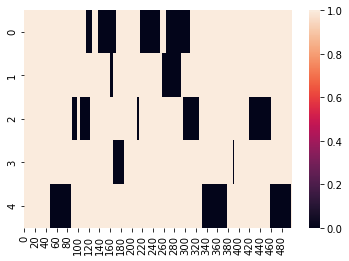

In [5]:
W = missing_matrix(X, missing_len=0.1, missing_num=20)
missing_X = to_missing_X(X, W)
linear_X = interpolate_matrix(missing_X, how='linear')
initial_X = copy.copy(linear_X)

print('number of missing value', np.count_nonzero(np.isnan(missing_X)))
#missing values are black
sns.heatmap(W.T)

In [6]:
def heatmap_plot(X):
	fig = plt.figure()
	plt.figure(figsize=(8,8))
	ax1 = fig.add_subplot(521)
	ax1.plot(x1,color='b')
	ax2 = fig.add_subplot(523)
	ax2.plot(x2,color='b')
	ax2.plot(x1,color='b',linestyle='dashed')
	ax3 = fig.add_subplot(525)
	ax3.plot(x3,color='b')
	ax3.plot(x1,color='b',linestyle='dashed')
	ax3 = fig.add_subplot(527)
	ax3.plot(x4,color='b')
	ax3.plot(x1,color='b',linestyle='dashed')
	ax4 = fig.add_subplot(529)
	ax4.plot(x5,color='b')
	ax4.plot(x1,color='b',linestyle='dashed')

	ax5 = fig.add_subplot(122)
	ax5.imshow(X, cmap='binary')

In [7]:
#pykalmanから継承して、emだけ変更。predicted_state_means (,predicted_state_covariances)が欲しかった。
class KalmanFilter_part(KalmanFilter):

    def em(self, X, y=None, n_iter=10, em_vars=None):
        Z = self._parse_observations(X)

        # initialize parameters
        (self.transition_matrices, self.transition_offsets,
         self.transition_covariance, self.observation_matrices,
         self.observation_offsets, self.observation_covariance,
         self.initial_state_mean, self.initial_state_covariance) = (
            self._initialize_parameters()
        )

        # Create dictionary of variables not to perform EM on
        if em_vars is None:
            em_vars = self.em_vars

        if em_vars == 'all':
            given = {}
        else:
            given = {
                'transition_matrices': self.transition_matrices,
                'observation_matrices': self.observation_matrices,
                'transition_offsets': self.transition_offsets,
                'observation_offsets': self.observation_offsets,
                'transition_covariance': self.transition_covariance,
                'observation_covariance': self.observation_covariance,
                'initial_state_mean': self.initial_state_mean,
                'initial_state_covariance': self.initial_state_covariance
            }
            em_vars = set(em_vars)
            for k in list(given.keys()):
                if k in em_vars:
                    given.pop(k)

        # If a parameter is time varying, print a warning
        for (k, v) in get_params(self).items():
            if k in DIM and (not k in given) and len(v.shape) != DIM[k]:
                warn_str = (
                    '{0} has {1} dimensions now; after fitting, '
                    + 'it will have dimension {2}'
                ).format(k, len(v.shape), DIM[k])
                warnings.warn(warn_str)

        # Actual EM iterations
        for i in range(n_iter):
            (predicted_state_means, predicted_state_covariances,
             kalman_gains, filtered_state_means,
             filtered_state_covariances) = (
                _filter(
                    self.transition_matrices, self.observation_matrices,
                    self.transition_covariance, self.observation_covariance,
                    self.transition_offsets, self.observation_offsets,
                    self.initial_state_mean, self.initial_state_covariance,
                    Z
                )
            )
            (smoothed_state_means, smoothed_state_covariances,
             kalman_smoothing_gains) = (
                _smooth(
                    self.transition_matrices, filtered_state_means,
                    filtered_state_covariances, predicted_state_means,
                    predicted_state_covariances
                )
            )
            sigma_pair_smooth = _smooth_pair(
                smoothed_state_covariances,
                kalman_smoothing_gains
            )
            (self.transition_matrices,  self.observation_matrices,
             self.transition_offsets, self.observation_offsets,
             self.transition_covariance, self.observation_covariance,
             self.initial_state_mean, self.initial_state_covariance) = (
                _em(Z, self.transition_offsets, self.observation_offsets,
                    smoothed_state_means, smoothed_state_covariances,
                    sigma_pair_smooth, given=given
                )
            )
        return self, predicted_state_means, predicted_state_covariances

In [8]:
class LDS:
	def __init__(self, n_dim_state, n_dim_obs, model=None):
		n_dim_state = n_dim_state
		n_dim_obs = n_dim_obs

		if model:
			self.miu = model.miu
			self.A = model.A
			self.C = model.C
			self.Q = model.Q
			self.Q0 = model.Q0
			self.R = model.R
		else:
			self.miu = np.random.randn(n_dim_state)
			self.A = np.eye(n_dim_state, n_dim_state) + np.random.randn(n_dim_state, n_dim_state)
			self.C = np.eye(n_dim_obs, n_dim_state) + np.random.randn(n_dim_obs, n_dim_state)
			self.Q = np.eye(n_dim_state, n_dim_state)
			self.Q0 = self.Q
			self.R = np.eye(n_dim_obs, n_dim_obs)

	def fit(self, X):
		kf = KalmanFilter_part( initial_state_mean=self.miu,
						initial_state_covariance=self.Q0,
						transition_matrices=self.A,
						transition_covariance=self.Q,
						observation_matrices=self.C,
						observation_covariance=self.R)
			
		kf, predict_mean, predict_var = kf.em(X,em_vars=['transition_matrices','transition_covariance', 'observation_matrices','observation_covariance'],n_iter=1)
		self.miu = kf.initial_state_mean
		self.A = kf.transition_matrices
		self.C = kf.observation_matrices
		self.Q = kf.transition_covariance
		self.Q0 = kf.initial_state_covariance
		self.R = kf.observation_covariance

		return predict_mean, predict_var

In [9]:
def isTiny(sigma):
	eps = 1.0e-10
	return (np.linalg.norm(sigma,1) < eps) or (np.any(np.diag(sigma) < eps))

def DynaMMo(initial_X, W, n_dim_state=6, n_iter=10):
	N = initial_X.shape[0]
	H = n_dim_state
	dim = initial_X.shape[1]

	for n in range(n_iter):
		if n==0:
			lds = LDS(n_dim_state=H,n_dim_obs=dim)
		else:
			lds = LDS(n_dim_state=H, n_dim_obs=dim, model=lds)

		predict_mean, predict_var = lds.fit(initial_X)

		Y = np.empty(initial_X.shape)
		for i in range(N):
			Y[i] = lds.C @ predict_mean[i]
			for j in range(dim):
				if W[i,j]==0:
					initial_X[i,j] = Y[i,j]
		
		if (isTiny(lds.Q0) or isTiny(lds.Q) or isTiny(lds.R)):
			print('converged at n_iter=',n)
			break
		if n==n_iter-1:
			print('not converged until n_iter=',n_iter)
	
	return initial_X

In [10]:
dynammo_X = DynaMMo(initial_X, W, n_dim_state=6, n_iter=200)

converged at n_iter= 66


<AxesSubplot:>

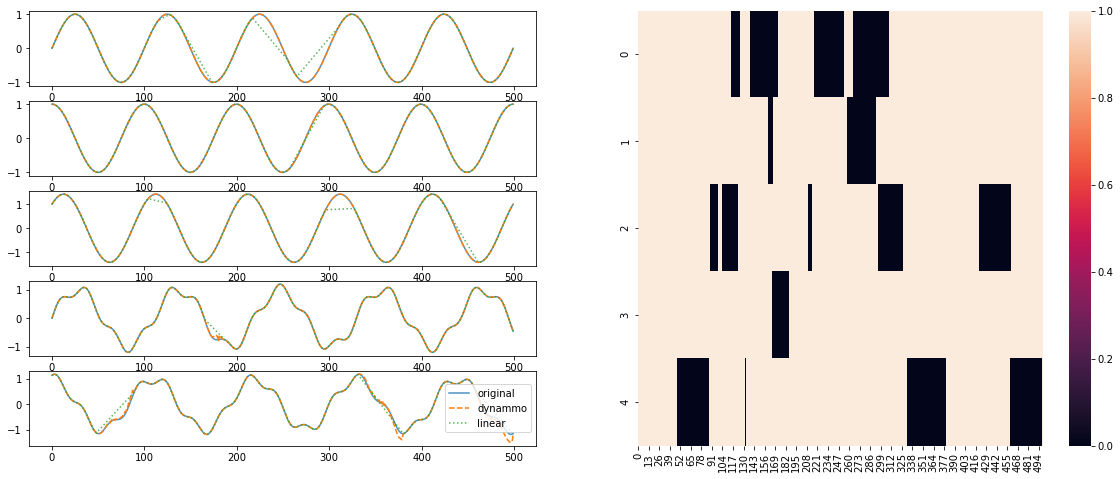

In [11]:
ori_alpha=0.8
sp_alpha=0.8
plt.figure(figsize=(20,8))
plt.subplot(521)
plt.plot(x1, label='original', alpha=ori_alpha)
plt.plot(dynammo_X[:,0], label='dynammo', linestyle='dashed')
plt.plot(linear_X[:,0], label='linear', alpha=sp_alpha, linestyle='dotted')
plt.subplot(523)
plt.plot(x2, label='original', alpha=ori_alpha)
plt.plot(dynammo_X[:,1], label='dynammo', linestyle='dashed')
plt.plot(linear_X[:,1], label='linear', alpha=sp_alpha, linestyle='dotted')
plt.subplot(525)
plt.plot(x3, label='original', alpha=ori_alpha)
plt.plot(dynammo_X[:,2], label='dynammo', linestyle='dashed')
plt.plot(linear_X[:,2], label='linear', alpha=sp_alpha, linestyle='dotted')
plt.subplot(527)
plt.plot(x4, label='original', alpha=ori_alpha)
plt.plot(dynammo_X[:,3], label='dynammo', linestyle='dashed')
plt.plot(linear_X[:,3], label='linear', alpha=sp_alpha, linestyle='dotted')
plt.subplot(529)
plt.plot(x5, label='original', alpha=ori_alpha)
plt.plot(dynammo_X[:,4], label='dynammo', linestyle='dashed')
plt.plot(linear_X[:,4], label='linear', alpha=sp_alpha, linestyle='dotted')
plt.legend()
plt.subplot(122)
sns.heatmap(W.T)